<a href="https://colab.research.google.com/github/yaniv-aknin/fafanalysis/blob/main/Rating%2C_Faction_and_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question

The other day I saw [this discussion](https://faforever.zulipchat.com/#narrow/stream/203479-random/topic/random/near/289426897) on the FAF Zulip chat, asking about the relationship between faction, rating, and result (win/loss):
> ![discussion screenshot](https://user-images.githubusercontent.com/101657/178927967-f7d8e3ed-6360-4edf-b0df-a44a4113788a.png)

I felt it's something that can easily be answered with my [fafdata dataset](https://www.kaggle.com/datasets/yanivaknin/fafdata).

In [1]:
# Boilerplate
from google.colab import auth
auth.authenticate_user()
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(18,14)})

# The query

We see two queries here.

The subquery `playerstats` flattens and extracts the important values from the (nested and denormalized) view of all games. We end up with two rows for every valid 1v1 game, one row per player. Each row shows the rating before the game, the result (win/loss/etc) and the faction. We can see we filter on `leaderboard_leaderboard_id = 2`, that's [the 1v1 ladder](https://api.faforever.com/data/leaderboard/2).

The main query then does the counting and grouping:
* We bin players' rating into bins worth 100 rating points, and group by bins and faction
* We count all `VICTORY` games over all `VICTORY` and `DEFEAT` games, ignoring the other cases (`DRAW` etc).
* We also count how many games went into every group, to size the points in the scatter plot below

In [24]:
query = """
WITH playerstats AS (
    SELECT
    ROUND(ps.beforeMean - 3 * ps.beforeDeviation, 1) player_before_rating,
    ps.result player_result,
    `fafalytics.faf_ladder_1v1.FACTION_NAME`(ps.faction) player_faction,
  FROM `fafalytics.faf.games_denorm` g
  CROSS JOIN UNNEST(playerStats_gamePlayerStats) ps
  CROSS JOIN UNNEST(ratingChanges_leaderboardRatingJournal) lb
  WHERE validity = "VALID"
    AND lb.leaderboard_leaderboard_id = 2
)

SELECT
  CAST(player_before_rating/100 AS INT64)*100 rating_bin,
  SAFE_DIVIDE(COUNTIF(player_result = "VICTORY"), COUNTIF(player_result IN ("VICTORY", "DEFEAT"))) victory_rate,
  player_faction faction,
  COUNT(*) number_of_games
FROM playerstats
GROUP BY rating_bin, faction
"""

df = pd.read_gbq(query, project_id='fafalytics')

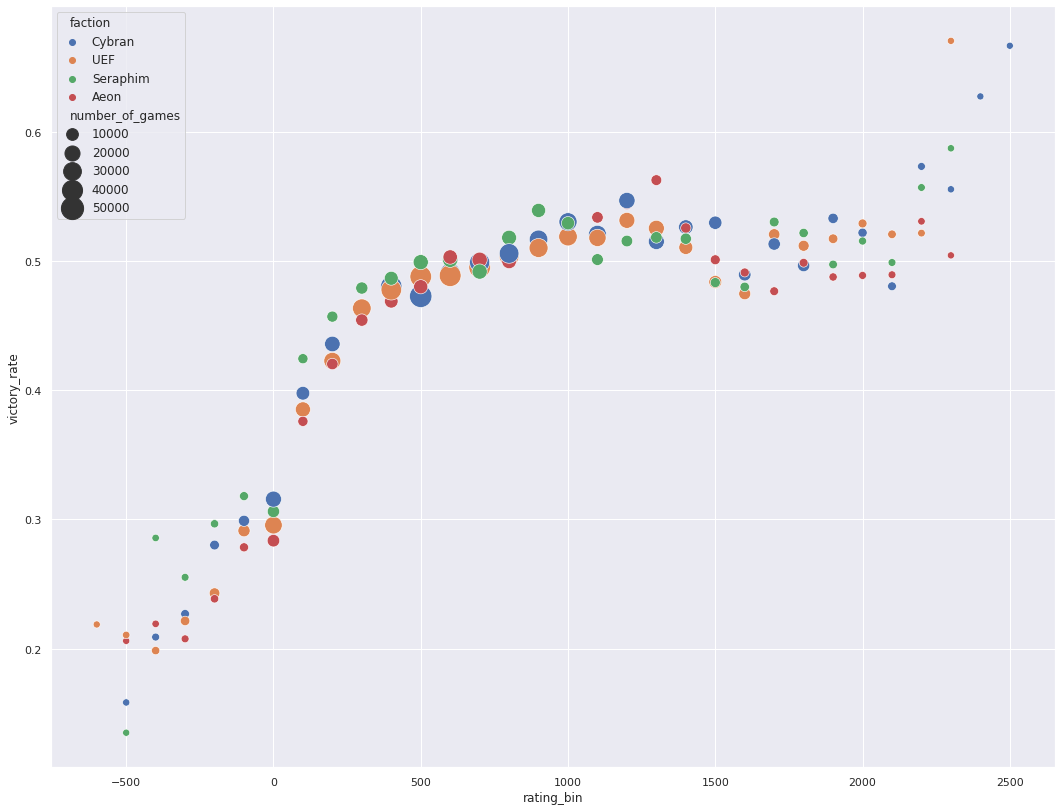

In [23]:
sns.scatterplot(data=df[(df.number_of_games>50) & (df.faction != "Other")], x="rating_bin", y="victory_rate", hue="faction", size="number_of_games", sizes=(50,500))

# Discussion

* As we'd expect, higher rated players win more (...).
* We also see that Seraphim tends to win more at the 0-1,000 rating.
* The picture is less clear above 1,000 rating, but perhaps Cybran is prevalent at the 1,000-2,000 range.
* Finally, at the really top levels (2,000+) it's hard to say which faction wins more, and also the number of games played isn't very high.

# Shameful plug
Want me to do another analysis? Why not head over to the [fafanalysis issue page](https://github.com/yaniv-aknin/fafanalysis/issues) and file a new request?

All the data is shared publiclicly, and you should be able to run the queries in this colab in your own BigQuery account (you'll pay for query costs, I pay for storage).